### Time series: Energy Consumption
In this notebook some regression models are trained to forecast the consumption of energy given a prestablished period. The periods to test are the following.

- 5 hours to predict next hour \[5h1h\]
- 3 days (average per day) to predict next day \[3d1d\]
- 1 month (average per month) to predict next month \[1m1m\]

The data it is rearranged and stored in separated files to train the ML models. In another notebook deep learning models are tested and the original file is used.

On the other hand the models to test are the following
- Ridge Regression *(sklearn.linear_model.Ridge)*
- Bayessian Ridge Regression *(sklearn.linear_model.BayesianRidge)*
- SVM regressor *(sklearn.svm.SVR)*
- SDG Regressor *(sklearn.linear_model.SGDRegressor)*
- MLPN Regressor *(sklearn.neural_network.MLPRegressor)*

In [2]:
import sklearn
from sklearn.linear_model import RidgeCV as Ridge, BayesianRidge as BRidge, SGDRegressor as SGDR
from sklearn.neighbors import KNeighborsRegressor as KNNR, RadiusNeighborsRegressor as RNNR
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as MLPR
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import norm
from time import time
from sklearn.preprocessing import MinMaxScaler as mms

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# gets the sliding window element of a series
def slide_window(series, window_size, step):
    i = 0
    while (i + step + 1) < len(series):
        yield series[i:i+window_size].values
        i += step

# global parameters
filename = 'AEP_hourly_trimed.csv'
datadir = 'data'


In [3]:
# read data file
data = pd.read_csv(('%s/%s')%(datadir,filename), parse_dates=['Datetime'], index_col=[0], squeeze=True)
# rearrange data and store in different files

# 3 days - next day
temp = pd.DataFrame([x for x in slide_window(data.groupby(lambda x: x.date).mean(), 4, 1)])
temp.to_csv('%s/AEP_3d.csv'%(datadir),index=False,header=False)

# 1 month - next month
temp = pd.DataFrame([x for x in slide_window(data.groupby([data.index.year, data.index.month]).mean(), 2, 1)])
temp.to_csv('%s/AEP_1m.csv'%(datadir),index=False,header=False)

# 2 months - next month
temp = pd.DataFrame([x for x in slide_window(data.groupby([data.index.year, data.index.month]).mean(), 3, 1)])
temp.to_csv('%s/AEP_2m.csv'%(datadir),index=False,header=False)

# 5 hrs - next hour
temp = pd.DataFrame([x for x in slide_window(data, 6, 1)])
temp.to_csv('%s/AEP_5h.csv'%(datadir),index=False,header=False)

# 1 year - next year
temp = pd.DataFrame([x for x in slide_window(data.groupby(lambda x: x.month).mean(), 2, 1)])
temp.to_csv('%s/AEP_1y.csv'%(datadir),index=False,header=False)

# 5 hours to predict 1 hour ahead

## Ridge Regression
First atempt is to test simple linear model with ridge regression, generalized cross-validation (leave-one-out) is used for model selection varying the values of alpha parameter. 2/3 of data was used as developement set and the rest is evaluated with R2 score. Finally the predicted test values are compared against the original test values visually in a plot.

In [4]:
# Read data
data = pd.read_csv('%s/AEP_5h.csv'%(datadir), header=None)
data.dropna(inplace=True) # drop last rows with NaN values
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], test_size=0.33, random_state=42)

print('Data resume')
print()
print(data.describe())

Data resume

                   0              1              2              3  \
count  121100.000000  121100.000000  121100.000000  121100.000000   
mean    15501.009628   15501.043179   15501.077696   15501.112444   
std      2591.745317    2591.730838    2591.709608    2591.682939   
min      9581.000000    9581.000000    9581.000000    9581.000000   
25%     13632.000000   13632.000000   13632.000000   13632.000000   
50%     15311.500000   15312.000000   15312.000000   15312.000000   
75%     17203.000000   17203.000000   17203.000000   17203.000000   
max     25695.000000   25695.000000   25695.000000   25695.000000   

                   4              5  
count  121100.000000  121100.000000  
mean    15501.147250   15501.175475  
std      2591.654297    2591.626579  
min      9581.000000    9581.000000  
25%     13632.000000   13632.000000  
50%     15312.000000   15312.000000  
75%     17203.000000   17203.000000  
max     25695.000000   25695.000000  


Error mean and std per alpha value
alphas:  [0.1, 0.01, 0.001, 0.0001]
[-0.00584551 -0.00584551 -0.00584551 -0.00584551]
[2571.95318024 2571.95318024 2571.95318024 2571.95318024]
best alpha =  0.0001
R2 score on the test set =  -338.2054577863417


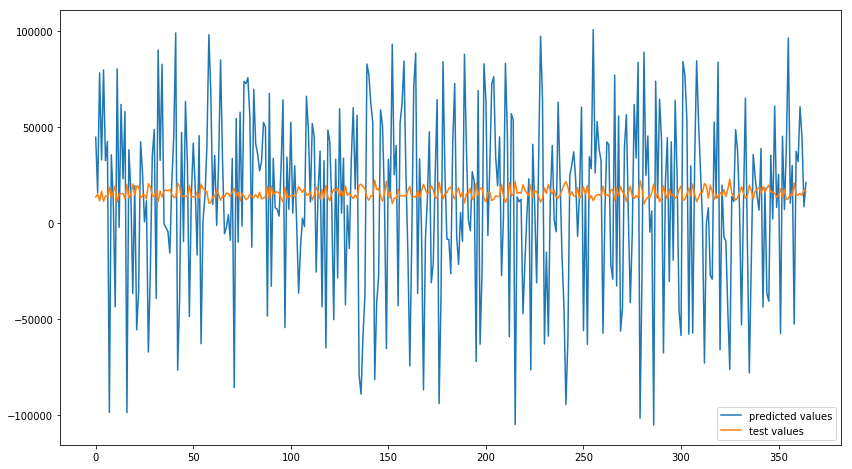

In [5]:
# Ridge Regression
## Parameters
alphas = [0.1, 0.01, 0.001, 0.0001]
score = 'r2'
cv = None
cv_values = True
ridge_estimator = Ridge(alphas = alphas, scoring=score, cv=cv, store_cv_values=cv_values)

ridge_estimator.fit(X_train, y_train)

print('Error mean and std per alpha value')
print('alphas: ', alphas)
print(ridge_estimator.cv_values_.mean(axis=0))
print(ridge_estimator.cv_values_.std(axis=0))
print('best alpha = ',ridge_estimator.alpha_)
print('R2 score on the test set = ', ridge_estimator.score(X_test, y_test))

y_pred = ridge_estimator.predict(X_test)

# plot the results
test_plot=365
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

Even though the score is not so far from 0 and mean of the errors also was near to 0 the standard deviation has a very large value, this can be seen easily in the plot, furthermore the plot shows that is has a poor performance, therefore another models have to be evaluated.

## Bayesian Ridge Regression

In this section the bayesian ridge regressor is tested, to train, a randomized search is made over a range of values for each parameter. The elapsed time is taken and the model is evaluated in the same way Ridge Regression was.

In [6]:
# specify parameters and distributions to sample from
param_dist = {"alpha_1": norm(loc=1e-6, scale=.02),
              "alpha_2": norm(loc=1e-6, scale=.02),
              "lambda_1": norm(loc=1e-6, scale=.02),
              "lambda_2": norm(loc=1e-6, scale=.02),
              "normalize": [True, False],
              "fit_intercept": [True, False]}

regressor = BRidge(n_iter=1000)

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, scoring=score)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=3)

RandomizedSearchCV took 7.46 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.985 (std: 0.002)
Parameters: {'alpha_1': -0.018132692158642345, 'alpha_2': -0.008661828249365063, 'fit_intercept': True, 'lambda_1': 0.02964754754593104, 'lambda_2': 0.02263932397588738, 'normalize': True}

Model with rank: 2
Mean validation score: 0.985 (std: 0.002)
Parameters: {'alpha_1': 0.013801365221450054, 'alpha_2': 0.022283076396878106, 'fit_intercept': True, 'lambda_1': 0.00577869064676002, 'lambda_2': 0.03913891099540764, 'normalize': True}

Model with rank: 3
Mean validation score: 0.985 (std: 0.002)
Parameters: {'alpha_1': 0.03676122044312474, 'alpha_2': 0.002891200130134078, 'fit_intercept': True, 'lambda_1': 0.0018788806733042174, 'lambda_2': 0.009999634802177196, 'normalize': True}



R2 score on the test set =  0.9863797254545781


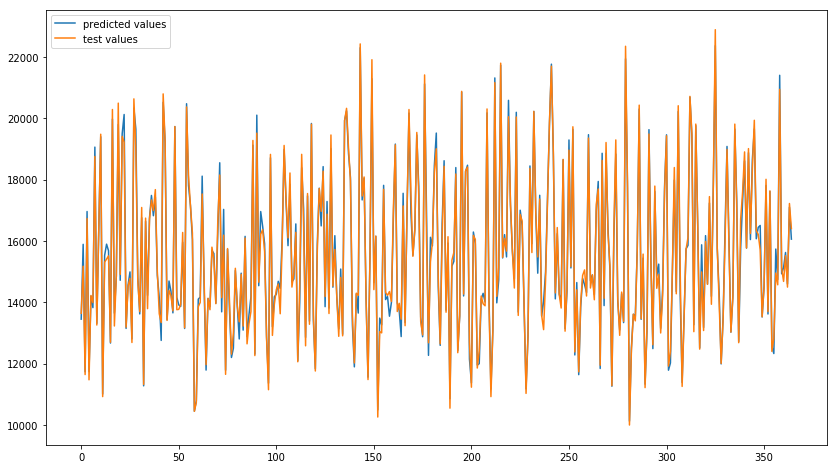

In [7]:
print('R2 score on the test set = ', random_search.score(X_test, y_test))

y_pred = random_search.predict(X_test)

# plot the results
test_plot=365
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

The Bayesian Ridge model has outstanding results over the ridge regression. As this model gave good results on the hours data it is going to be tested with the rest of the files.

# 3 days to predict next day
## Bayesian Ridge Regression

As the Bayesian model worked very well on the hour data it is going to be tested first to see if it can predict average cosumption of energy the next day after knowing the previous 3.

In [8]:
# Read data
data = pd.read_csv('%s/AEP_3d.csv'%(datadir), header=None)
data.dropna(inplace=True) # drop last rows with NaN values
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], test_size=0.33, random_state=42)

print('Data resume')
print()
print(data.describe())

Data resume

                  0             1             2             3
count   5044.000000   5044.000000   5044.000000   5044.000000
mean   15501.389467  15501.688353  15501.623598  15501.471578
std     1971.451009   1971.384483   1971.424738   1971.537352
min    11078.041667  11078.041667  11078.041667  11078.041667
25%    14071.635417  14071.635417  14071.635417  14066.197917
50%    15273.083333  15273.229167  15273.229167  15273.229167
75%    16807.520833  16807.520833  16807.520833  16807.520833
max    22847.875000  22847.875000  22847.875000  22847.875000


In [9]:
# specify parameters and distributions to sample from
param_dist = {"alpha_1": norm(loc=1e-6, scale=.2),
              "alpha_2": norm(loc=1e-6, scale=.2),
              "lambda_1": norm(loc=1e-6, scale=.2),
              "lambda_2": norm(loc=1e-6, scale=.2),
              "normalize": [True, False],
              "fit_intercept": [True, False]}

regressor = BRidge(n_iter=5000)

# run randomized search
n_iter_search = 25
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, n_jobs=-2,
                                   n_iter=n_iter_search, cv=10, scoring=score)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=5)

RandomizedSearchCV took 7.73 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.760 (std: 0.023)
Parameters: {'alpha_1': -0.07442889902801862, 'alpha_2': -0.04618129063052845, 'fit_intercept': True, 'lambda_1': -0.21418979141980074, 'lambda_2': -0.03359597795351648, 'normalize': False}

Model with rank: 2
Mean validation score: 0.760 (std: 0.023)
Parameters: {'alpha_1': -0.05391717882197325, 'alpha_2': 0.28632109070938094, 'fit_intercept': True, 'lambda_1': -0.16803260126862288, 'lambda_2': -0.04124803994830072, 'normalize': False}

Model with rank: 3
Mean validation score: 0.760 (std: 0.023)
Parameters: {'alpha_1': -0.022335810539266664, 'alpha_2': 0.09809350875546816, 'fit_intercept': True, 'lambda_1': 0.21018532239563956, 'lambda_2': 0.009408183479790059, 'normalize': False}

Model with rank: 4
Mean validation score: 0.760 (std: 0.023)
Parameters: {'alpha_1': 0.04637901304376411, 'alpha_2': 0.14770607786080486, 'fit_intercept': True, 'lambda_1'

R2 score on the test set =  0.7583417274288901


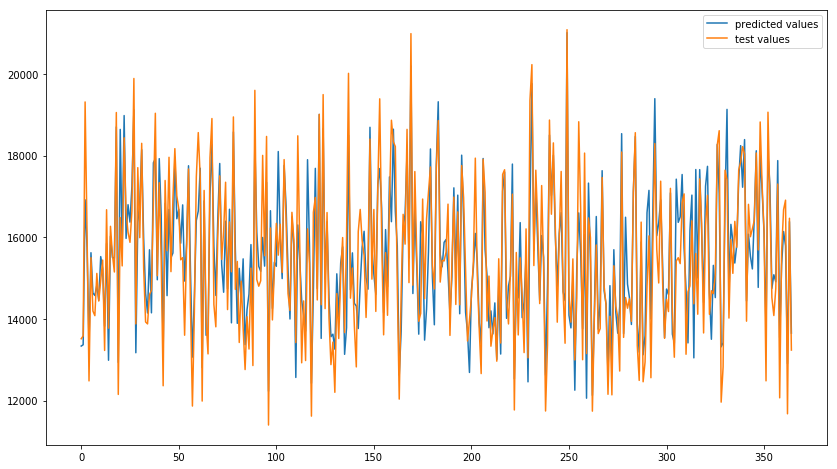

In [10]:
print('R2 score on the test set = ', random_search.score(X_test, y_test))

y_pred = random_search.predict(X_test)

# plot the results
test_plot=365
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

Although the results are not bad, they where not as good as expected. This may have been due to lack of data. Next another models are going to be tested to find the best one.
## SVM Regresor
### RBF Kernel

In [11]:
# specify parameters and distributions to sample from
param_dist = {"epsilon": [100,10,1,.1,.01,.001,.0001],
              "C": norm(loc=10000, scale=2000)}

regressor = SVR(kernel='rbf', gamma='scale')

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, n_jobs=-2,
                                   n_iter=n_iter_search, cv=10, scoring=score, error_score=np.nan)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=5)

RandomizedSearchCV took 297.26 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.785 (std: 0.026)
Parameters: {'C': 13304.442224157827, 'epsilon': 100}

Model with rank: 2
Mean validation score: 0.784 (std: 0.026)
Parameters: {'C': 12445.207553434082, 'epsilon': 0.1}

Model with rank: 3
Mean validation score: 0.784 (std: 0.026)
Parameters: {'C': 8830.265860908006, 'epsilon': 0.1}

Model with rank: 4
Mean validation score: 0.784 (std: 0.026)
Parameters: {'C': 10452.053078707482, 'epsilon': 10}

Model with rank: 5
Mean validation score: 0.784 (std: 0.026)
Parameters: {'C': 8707.690477447606, 'epsilon': 1}



R2 score on the test set =  0.7812360250886277


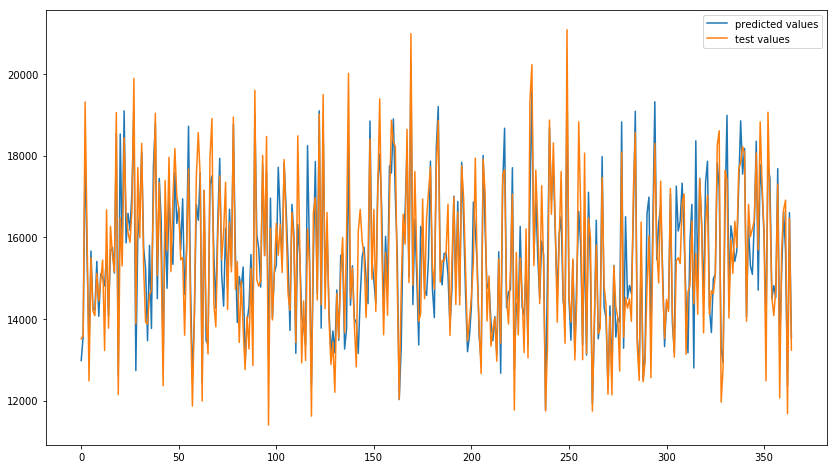

In [12]:
print('R2 score on the test set = ', random_search.score(X_test, y_test))

y_pred = random_search.predict(X_test)

# plot the results
test_plot=365
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

Note: the polynomial kernel was tested, but it took a lot of time to compute even with a low grade polynomial (3rd grade), I guess that the function that calculates the new feature from the kernel computes the full polynomial which makes the mapped data present a very high dimension, in this case there are 3 independent variables (3 days to predict next day) with the full expansion it gives us 27 different terms expanding the dimension of the mapped data.
## MLPN Regressor

R2 score on the test set =  0.7662025469190099


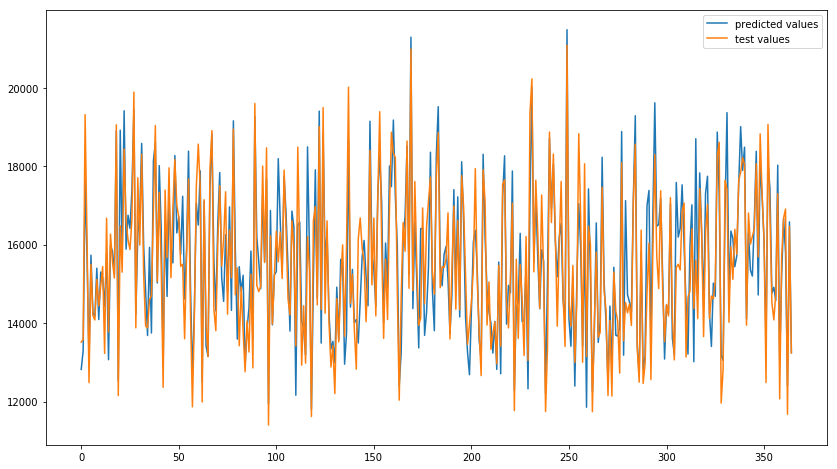

In [13]:
random_search = MLPR(activation='relu', solver='adam', max_iter=10000, 
                     learning_rate='constant', learning_rate_init=.001,
                    hidden_layer_sizes=(100,), alpha=.001, random_state=42,
                    beta_1=.9)
#best alpha = .001
#best hidden_layer_sizes = (100,)
#best learning_rate_init=.001 - 0.7662025469190099
random_search.fit(X_train, y_train)

print('R2 score on the test set = ', random_search.score(X_test, y_test))

y_pred = random_search.predict(X_test)

# plot the results
test_plot=365
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

As seen in the last 2 graphs the best performance so far is yielded by the RBF kernel SVM, with almost 80% of precission.

# 1 Month to predict next month


In [14]:
! ls data

AEP_1m.csv  AEP_2m.csv	AEP_5h.csv	AEP_hourly_trimed.csv
AEP_1y.csv  AEP_3d.csv	AEP_hourly.csv	pjm_hourly_est.csv


In [15]:
# Read data
data = pd.read_csv('%s/AEP_1m.csv'%(datadir), header=None)
data.dropna(inplace=True) # drop last rows with NaN values
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], test_size=0.33, random_state=42)

print('Data resume')
print(data.describe())
print(data.head())

Data resume
                  0             1
count    164.000000    164.000000
mean   15502.443228  15510.210491
std     1475.240398   1470.794531
min    12805.127688  12805.127688
25%    14299.274207  14356.824762
50%    15277.482383  15291.775538
75%    16699.856519  16699.856519
max    19212.903274  19212.903274
              0             1
0  14031.418778  14830.440278
1  14830.440278  16737.720430
2  16737.720430  17117.088710
3  17117.088710  16496.644345
4  16496.644345  15924.061828


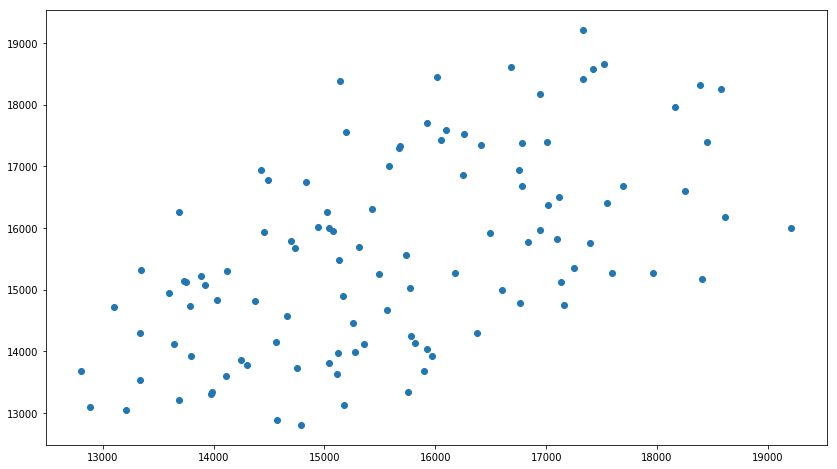

In [16]:

# Scatterplot to check relation between a month and the one before
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.scatter(X_train, y_train)
plt.show()

Seems that the data presents a slight correlation between a month and the previous one. There may be a higher order correlation between these variables wich will be captured (if so) by one of the proposed models.

Since last 2 models presented a good performance let's start from there. This time let's begin with a MLPN model and test its pferformance in the 1 month - 1 month dataset.
## MLPN

In [17]:
#random_search = MLPR(activation='relu', solver='adam', max_iter=10000, 
#                     learning_rate='constant', learning_rate_init=.01,
#                    hidden_layer_sizes=(100,), alpha=.0001, random_state=42,
#                    beta_1=.9)
random_search = MLPR()
random_search.fit(X_train, y_train)

print('R2 score on the test set = ', random_search.score(X_test, y_test))


R2 score on the test set =  -0.05838561223762206


After several tries, it seems an MLPN model has too much problems to handle this data, none of the MLPRegressor models (varying the parameters values) could achieve a good performance so this one is descarted.

## SVM Regressor with rbf kernel

In [18]:
# specify parameters and distributions to sample from
param_dist = {"epsilon": [100,10,1,.1,.01,.001,.0001],
              "C": norm(loc=500, scale=200)}

regressor = SVR(kernel='rbf', gamma='scale')

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, n_jobs=-2,
                                   n_iter=n_iter_search, cv=10, scoring=score, error_score=np.nan)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=5)

RandomizedSearchCV took 1.61 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.148 (std: 0.204)
Parameters: {'C': 256.84417696501254, 'epsilon': 10}

Model with rank: 2
Mean validation score: 0.148 (std: 0.205)
Parameters: {'C': 260.70777561423506, 'epsilon': 0.1}

Model with rank: 3
Mean validation score: 0.146 (std: 0.205)
Parameters: {'C': 239.10229182373808, 'epsilon': 0.1}

Model with rank: 4
Mean validation score: 0.143 (std: 0.213)
Parameters: {'C': 393.4999605546678, 'epsilon': 0.001}

Model with rank: 5
Mean validation score: 0.143 (std: 0.212)
Parameters: {'C': 355.00876534718674, 'epsilon': 100}



/home/sgm/source/timeseries/energy/ve-energy/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Opposed as believed, the performance of the two predictors used in the previous task do not show an adequate performance, hence there may not be a relation between a month mean energy consumption and the previous month. To verify, more models are going to be tested.

## SDG Regressor

In [25]:
# specify parameters and distributions to sample from
param_dist = {"alpha": [0.1,.01,.001,.0001, 0.0005],
              "loss": ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
             }

regressor = SGDR(penalty='l2', max_iter=10000, tol=0.001)

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, n_jobs=-2,
                                   n_iter=n_iter_search, cv=10, scoring=score, error_score=np.nan)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=5)

/home/sgm/source/timeseries/energy/ve-energy/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV took 1.89 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: -60.709 (std: 91.001)
Parameters: {'loss': 'huber', 'alpha': 0.01}

Model with rank: 2
Mean validation score: -93.975 (std: 93.784)
Parameters: {'loss': 'huber', 'alpha': 0.001}

Model with rank: 3
Mean validation score: -114.321 (std: 99.457)
Parameters: {'loss': 'huber', 'alpha': 0.0001}

Model with rank: 4
Mean validation score: -116.177 (std: 117.285)
Parameters: {'loss': 'huber', 'alpha': 0.1}

Model with rank: 5
Mean validation score: -139.497 (std: 115.807)
Parameters: {'loss': 'huber', 'alpha': 0.0005}



/home/sgm/source/timeseries/energy/ve-energy/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Ridge Regresor

Error mean and std per alpha value
alphas:  [0.1, 0.01, 0.001, 0.0001]
[1.21679373 1.21679373 1.21679373 1.21679373]
[878.05681635 878.05681668 878.05681672 878.05681672]
best alpha =  0.0001
R2 score on the test set =  0.30368700214904965


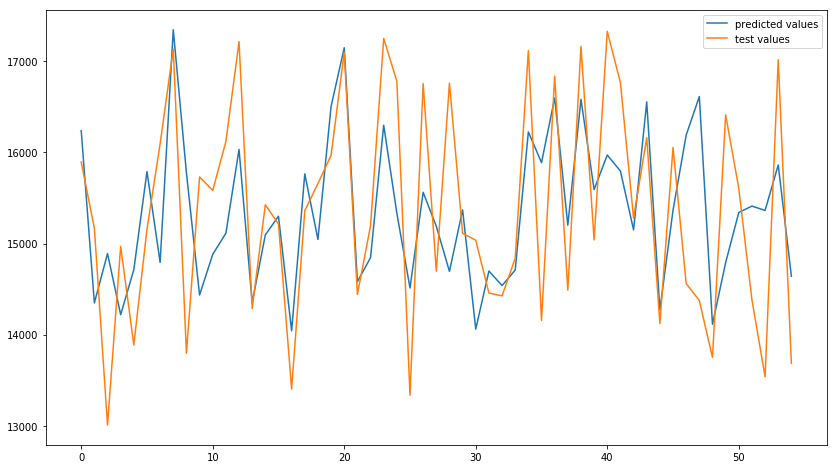

In [32]:
## Parameters
alphas = [0.1, 0.01, 0.001, 0.0001]
score = 'r2'
cv = None
cv_values = True
ridge_estimator = Ridge(alphas = alphas, scoring=score, cv=cv, store_cv_values=cv_values)

ridge_estimator.fit(X_train, y_train)

print('Error mean and std per alpha value')
print('alphas: ', alphas)
print(ridge_estimator.cv_values_.mean(axis=0))
print(ridge_estimator.cv_values_.std(axis=0))
print('best alpha = ',ridge_estimator.alpha_)
print('R2 score on the test set = ', ridge_estimator.score(X_test, y_test))

y_pred = ridge_estimator.predict(X_test)

# plot the results
test_plot=y_test.shape[0]
x = np.arange(0,test_plot)
plt.figure(figsize=(14,8))
plt.plot(x, y_pred[:test_plot], x, y_test[:test_plot])
plt.legend(('predicted values','test values'))
plt.show()

## Bayesian Ridge Regression

In [34]:
# specify parameters and distributions to sample from
param_dist = {"alpha_1": norm(loc=1e-6, scale=.02),
              "alpha_2": norm(loc=1e-6, scale=.02),
              "lambda_1": norm(loc=1e-6, scale=.02),
              "lambda_2": norm(loc=1e-6, scale=.02),
              "normalize": [True, False],
              "fit_intercept": [True, False]}

regressor = BRidge(n_iter=1000)

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regressor, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, scoring=score)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(random_search.cv_results_, n_top=5)

RandomizedSearchCV took 1.60 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.164 (std: 0.314)
Parameters: {'alpha_1': -0.006438234057745097, 'alpha_2': 0.01975016640962372, 'fit_intercept': True, 'lambda_1': 0.01926074911720724, 'lambda_2': -0.009629474950978996, 'normalize': False}

Model with rank: 2
Mean validation score: 0.164 (std: 0.314)
Parameters: {'alpha_1': 0.0171042600359859, 'alpha_2': 0.028743646004408156, 'fit_intercept': True, 'lambda_1': 0.0031886187273888547, 'lambda_2': -0.012415486781617528, 'normalize': False}

Model with rank: 3
Mean validation score: 0.164 (std: 0.315)
Parameters: {'alpha_1': 0.04013064197594766, 'alpha_2': 0.02817017864057014, 'fit_intercept': True, 'lambda_1': 0.009418883954319687, 'lambda_2': 0.0012380399109049422, 'normalize': False}

Model with rank: 4
Mean validation score: 0.164 (std: 0.316)
Parameters: {'alpha_1': 0.02027021701948289, 'alpha_2': 0.01625764853817375, 'fit_intercept': True, 'lambda_1

/home/sgm/source/timeseries/energy/ve-energy/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
